In [1]:
import datetime
import os

import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objs as go
init_notebook_mode(connected=True)


print(os.getcwd())

/Users/DayTightChunks/Documents/PhD/Models/phd-model-visuals


In [2]:
gen = "Gen1"
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [3]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue

# Extracting observed Conc.

## Define transect

In [4]:
comp = pd.read_table(path + 'observations/d13c_comp_cal.tss')
comp.head()

,Jdays,Transect,IDcal,d13C,d13C.SD
0,188,N,N-188,-31.400000,0.500000
1,188,S,S-188,-31.233333,0.513160
2,188,V,V-188,-29.966667,0.404145
3,197,N,N-197,-31.200000,0.100000
4,197,S,S-197,-31.066667,0.450925


In [5]:
det = pd.read_table(path + 'observations/d13c_det_cal.tss')
det.head()

,Jdays,Transect,IDcal,d13C,d13C.SD
0,181,N,N2-181,-30.663750,0.113573
1,181,V,V9-181,-31.019600,0.267031
2,182,S,S12-182,-31.583333,0.201699
3,182,S,S11-182,-31.150667,0.270152
4,197,S,S13-197,-31.442000,0.070711


In [6]:
obs = pd.concat([comp, det])
obs.head()

,Jdays,Transect,IDcal,d13C,d13C.SD
0,188,N,N-188,-31.400000,0.500000
1,188,S,S-188,-31.233333,0.513160
2,188,V,V-188,-29.966667,0.404145
3,197,N,N-197,-31.200000,0.100000
4,197,S,S-197,-31.066667,0.450925


# Selecting indexes

In [7]:
df = get_data(gen=gen)

In [8]:
# 'LHS_s2fix7/10/' in list(df.index)
# list(df)

In [9]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-tra'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-tra'])/2.0
df['Constraint'] = df.apply(WithIsoKGE, args=(0.6,), axis=1)

In [10]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-tra'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-tra'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.7856671938254698, 0.5624784847441313)
Maximum Conc.
(0.712486405538371, 0.36008130938978367, 0.4911975969993577)
Maximum d13C
(0.9031088875320538, 0.70432567774303, 0.7895610427604134)


In [11]:
dfs = df[['Model',
#           'dt_50_ref',
#           'k_d',
#           'epsilon_iso',
          'KGE-SM', 'KGE-d13C', 'Constraint'
          ]]

In [12]:
# Filter
ff = dfs.loc[(dfs['KGE-SM'] > 0.21)] # Try 25 with more data points
ff_c = ff.loc[(ff['KGE-d13C'] > 0.6)]
print(len(dfs), len(ff), len(ff_c))
ff.tail()

(7570, 486, 23)


,Model,KGE-SM,KGE-d13C,Constraint
LHS_sc1fix6/60/,fix,0.250903,-0.866467,NC
LHS_sc1var1/319/,var,0.244648,-1.176122,NC
LHS_sc1var1/64/,var,0.425198,0.222959,NC
LHS_sc1var3/83/,var,0.325851,-1.289182,NC
LHS_sc1var3/96/,var,0.237736,0.227875,NC


In [13]:
nc = ff.index[(ff['Constraint'] == 'NC')].tolist() #[0]
wc = ff.index[(ff['Constraint'] == 'WC') & (ff['Model']=='var') ].tolist() #[0]
print(len(nc), len(wc))

# nc = nc[0:len(wc)]

print(len(nc), len(wc))

(463, 14)
(463, 14)


In [14]:
path += gen + '/'

# Extracting time series

In [15]:
def get_sets(name_list, filename, vname):
    sets = []
    for i in range(len(name_list)):
        # Define variable name
        series_name = vname + name_list[i][3:] # Variable + set's name
        # Get sim TSS
        sim = pd.read_table(path + name_list[i] + filename, 
                       skiprows=4, delim_whitespace=True,
                                    names=['Jdays', series_name],
                                    header=None
                      )
        sim = sim[['Jdays', series_name]]
        sets.append(sim)
    df = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)
    return df

# Confidence interval calc.

In [16]:
def concat(row, plot):
    return plot.capitalize() + '-' + str(int(row['Jdays']))

In [17]:
def get_stats_df(df, loc, level, cst):
    n = len(np.array(df.iloc[0,1:]))
    df['mean'] = df.iloc[:,1:].mean(axis=1)
    df['min'] = df.iloc[:,1:].min(axis=1)
    df['max'] = df.iloc[:,1:].max(axis=1)
    df['sem'] = df.iloc[:,1:].sem(axis=1)
    df['high'] = df.apply(get_ci, args=(n, 0.95, True), axis=1)
    df['low'] = df.apply(get_ci, args=(n, 0.95, False), axis=1)
#     df['low'] = df.apply(check_negative, axis=1)
    df['Trans'] = loc
    df['Area'] = loc[0]
    df['Level'] = level  # Composite or Detailed, 
    df['IDcal'] = df.apply (lambda row: concat(row, loc), axis=1)
    df['Type'] = df.apply(lambda row: ModelType(row, cst),axis=1)
    return df[['Jdays', 'mean', 'high', 'low', 'max', 'min', 'Trans', 'Area', 'Level', 'IDcal', 'Type']]

In [18]:
comp = ['nor', 'val', 'sou']

det = ['n1', 'n2', 'n4', 'n7', 'n8',
       'v4', 'v7', 'v8', 'v9', 'v10',
       's11', 's12', 's13']

levels = ["Composite", "Detailed"]
label = ['No d13C', 'With d13C']

# constrained sets
wc_stat = []
for level in levels:
    if level == "Composite":
        smp = comp
        end = 1
    else:
        smp = det
        end = None
        
    for i in range(len(smp)):
        filename = "resM_" + smp[i] + 'd13C_real.tss'
        sets = get_sets(wc, filename, smp[i]) # Returns sets merged
        df = get_stats_df(sets, smp[i][0:end].capitalize(), level, label[1]) # Analyzed sets, WC!

        wc_stat.append(df) # nc_stat 

wc_all = pd.concat(wc_stat)  


In [19]:
wc_all.head(4)

,Jdays,mean,high,low,max,min,Trans,Area,Level,IDcal,Type
0,166,-23.703371,-23.703305,-23.703438,-23.7031,-23.7035,N,N,Composite,N-166,With d13C
1,167,-23.702543,-23.702437,-23.702649,-23.7022,-23.7028,N,N,Composite,N-167,With d13C
2,168,-23.701793,-23.701645,-23.701941,-23.7013,-23.7022,N,N,Composite,N-168,With d13C
3,169,-23.701100,-23.700910,-23.701290,-23.7004,-23.7016,N,N,Composite,N-169,With d13C


In [20]:
# wc_all.loc[wc_all['Trans']=='V10']

In [21]:
wc_merged = pd.merge(wc_all, obs, how='outer', on='IDcal')
wc_merged.tail(2)

,Jdays_x,mean,high,low,max,min,Trans,Area,Level,IDcal,Type,Jdays_y,Transect,d13C,d13C.SD
1934,285,-27.692171,-27.379271,-28.005071,-26.5458,-28.5871,S13,S,Detailed,S13-285,With d13C,NaN,NaN,NaN,NaN
1935,286,-27.646593,-27.330507,-27.962679,-26.4878,-28.5503,S13,S,Detailed,S13-286,With d13C,286.0,S,-28.415,0.407294


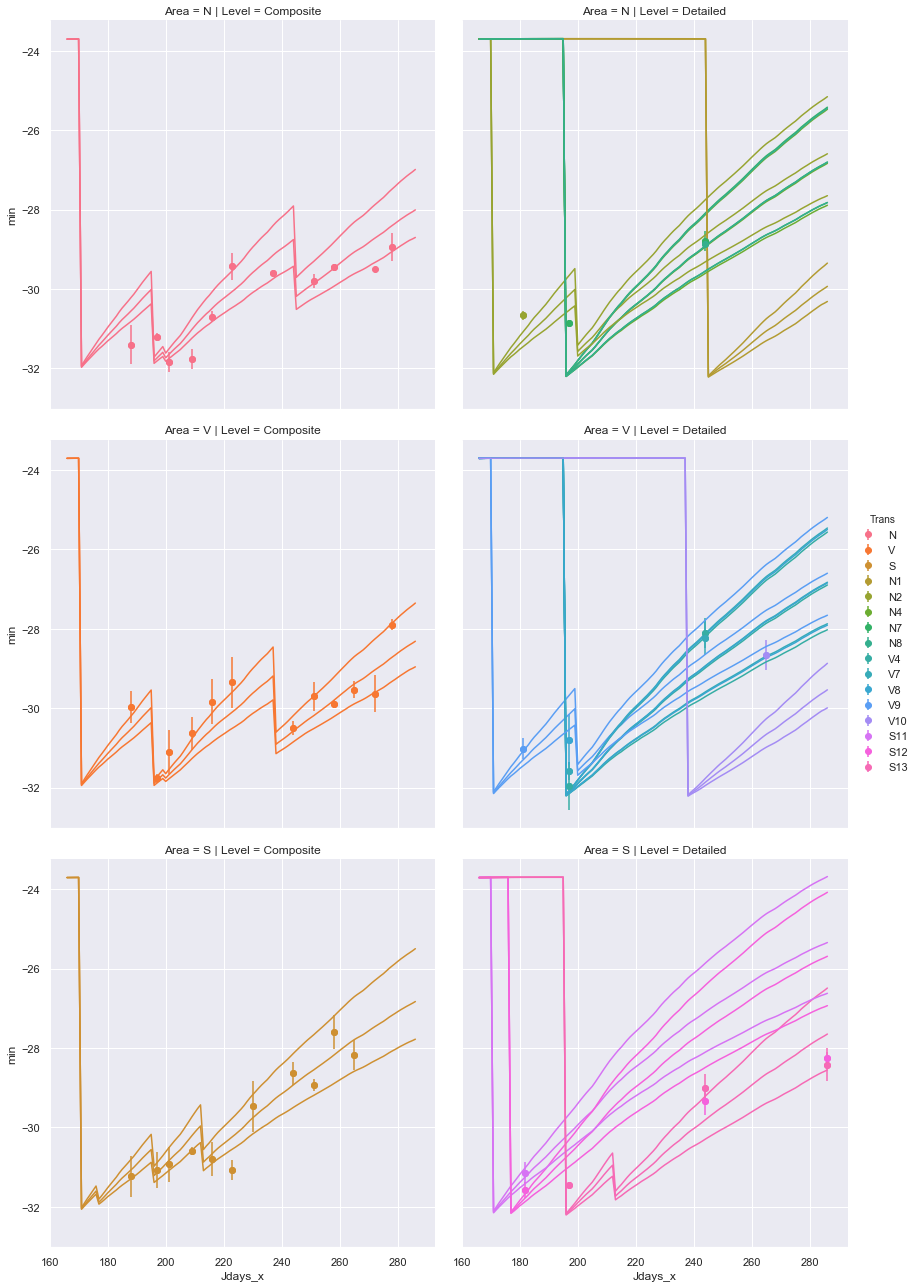

In [22]:
g = sns.FacetGrid(wc_merged, row="Area", col="Level", hue='Trans', height=6)
g.map(plt.scatter, "Jdays_x", "d13C")
g.map(plt.errorbar, "Jdays_x", "d13C", "d13C.SD", marker="o", linestyle='None')
g.map(plt.plot, "Jdays_x", "mean")
g.map(plt.plot, "Jdays_x", "max")
g.map(plt.plot, "Jdays_x", "min").add_legend()


# g.map(plt.plot, "Jdays_x", "max", color="r")